The aim of this notebook is to rework the Adjusted Rand Index metric to incorporate 
importance to smaller classes (which might be just as important). 

In [117]:
import os

from scipy import sparse as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets 
from sklearn import metrics 
from sklearn import cluster
from sklearn.utils import sparsefuncs

In [51]:
# Generate gaussian blobs simulating an imbalanced clustering setting
c_1 = np.random.normal(loc = 0, scale = 0.5, size = (500, 2))
c_2 = np.random.normal(loc = -2, scale = 0.1, size = (20, 2))
c_3 = np.random.normal(loc = 3, scale = 1, size = (500, 2))

<AxesSubplot:xlabel='x', ylabel='y'>

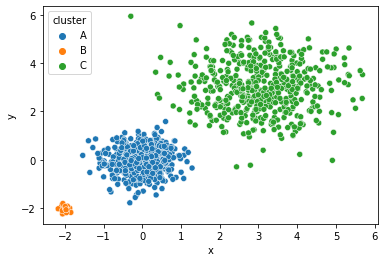

In [52]:
# Plot the given results 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "cluster": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "cluster",
    data = cluster_df
)

ARI value is: 0.946


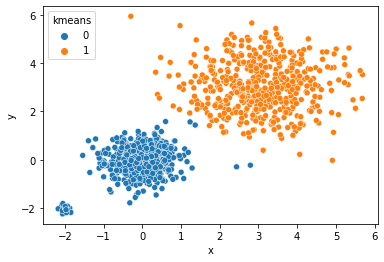

In [58]:
# Perform k-means clustering, calculate adjusted rand index 
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = cluster.KMeans(n_clusters = 2).fit_predict(X = cluster_arr)
cluster_df["kmeans"] = kmeans_res
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
ari_val = metrics.adjusted_rand_score(
    cluster_df.cluster,
    cluster_df.kmeans
)
print("ARI value is: " + str(round(ari_val, 3)))

This ARI value is quite high, even though we misclassified all of class B. Goal is to rework the ARI value by incorporating some sort of weighing metric based on the actual class/cluster label. The reweighing can happen based on the 'true cluster' information.

In [86]:
# First load the necessary functions from the sklearn library in bottom up order
def contingency_matrix(
    labels_true, labels_pred, *, eps=None, sparse=False, dtype=np.int64
):
    """Build a contingency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference.
    labels_pred : array-like of shape (n_samples,)
        Cluster labels to evaluate.
    eps : float, default=None
        If a float, that value is added to all values in the contingency
        matrix. This helps to stop NaN propagation.
        If ``None``, nothing is adjusted.
    sparse : bool, default=False
        If `True`, return a sparse CSR continency matrix. If `eps` is not
        `None` and `sparse` is `True` will raise ValueError.
        .. versionadded:: 0.18
    dtype : numeric type, default=np.int64
        Output dtype. Ignored if `eps` is not `None`.
        .. versionadded:: 0.24
    Returns
    -------
    contingency : {array-like, sparse}, shape=[n_classes_true, n_classes_pred]
        Matrix :math:`C` such that :math:`C_{i, j}` is the number of samples in
        true class :math:`i` and in predicted class :math:`j`. If
        ``eps is None``, the dtype of this array will be integer unless set
        otherwise with the ``dtype`` argument. If ``eps`` is given, the dtype
        will be float.
        Will be a ``sklearn.sparse.csr_matrix`` if ``sparse=True``.
    """

    if eps is not None and sparse:
        raise ValueError("Cannot set 'eps' when sparse=True")

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    # Using coo_matrix to accelerate simple histogram calculation,
    # i.e. bins are consecutive integers
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix(
        (np.ones(class_idx.shape[0]), (class_idx, cluster_idx)),
        shape=(n_classes, n_clusters),
        dtype=dtype,
    )
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            # don't use += as contingency is integer
            contingency = contingency + eps
    return contingency

def pair_confusion_matrix(labels_true, labels_pred):
    """Pair confusion matrix arising from two clusterings.
    The pair confusion matrix :math:`C` computes a 2 by 2 similarity matrix
    between two clusterings by considering all pairs of samples and counting
    pairs that are assigned into the same or into different clusters under
    the true and predicted clusterings.
    Considering a pair of samples that is clustered together a positive pair,
    then as in binary classification the count of true negatives is
    :math:`C_{00}`, false negatives is :math:`C_{10}`, true positives is
    :math:`C_{11}` and false positives is :math:`C_{01}`.
    Read more in the :ref:`User Guide <pair_confusion_matrix>`.
    Parameters
    ----------
    labels_true : array-like of shape (n_samples,), dtype=integral
        Ground truth class labels to be used as a reference.
    labels_pred : array-like of shape (n_samples,), dtype=integral
        Cluster labels to evaluate.
    Returns
    -------
    C : ndarray of shape (2, 2), dtype=np.int64
        The contingency matrix.
    See Also
    --------
    rand_score: Rand Score
    adjusted_rand_score: Adjusted Rand Score
    adjusted_mutual_info_score: Adjusted Mutual Information
    Examples
    --------
    Perfectly matching labelings have all non-zero entries on the
    diagonal regardless of actual label values:
      >>> from sklearn.metrics.cluster import pair_confusion_matrix
      >>> pair_confusion_matrix([0, 0, 1, 1], [1, 1, 0, 0])
      array([[8, 0],
             [0, 4]]...
    Labelings that assign all classes members to the same clusters
    are complete but may be not always pure, hence penalized, and
    have some off-diagonal non-zero entries:
      >>> pair_confusion_matrix([0, 0, 1, 2], [0, 0, 1, 1])
      array([[8, 2],
             [0, 2]]...
    Note that the matrix is not symmetric.
    References
    ----------
    .. L. Hubert and P. Arabie, Comparing Partitions, Journal of
      Classification 1985
      https://link.springer.com/article/10.1007%2FBF01908075
    """
    n_samples = np.int64(labels_true.shape[0])

    # Computation using the contingency data
    contingency = contingency_matrix(
        labels_true, labels_pred, sparse=True, dtype=np.int64
    )
    n_c = np.ravel(contingency.sum(axis=1))
    n_k = np.ravel(contingency.sum(axis=0))
    sum_squares = (contingency.data ** 2).sum()
    C = np.empty((2, 2), dtype=np.int64)
    C[1, 1] = sum_squares - n_samples
    C[0, 1] = contingency.dot(n_k).sum() - sum_squares
    C[1, 0] = contingency.transpose().dot(n_c).sum() - sum_squares
    C[0, 0] = n_samples ** 2 - C[0, 1] - C[1, 0] - sum_squares
    return C

def adjusted_rand_score(labels_true, labels_pred):
    """Rand index adjusted for chance.
    The Rand Index computes a similarity measure between two clusterings
    by considering all pairs of samples and counting pairs that are
    assigned in the same or different clusters in the predicted and
    true clusterings.
    The raw RI score is then "adjusted for chance" into the ARI score
    using the following scheme::
        ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    The adjusted Rand index is thus ensured to have a value close to
    0.0 for random labeling independently of the number of clusters and
    samples and exactly 1.0 when the clusterings are identical (up to
    a permutation).
    ARI is a symmetric measure::
        adjusted_rand_score(a, b) == adjusted_rand_score(b, a)
    Read more in the :ref:`User Guide <adjusted_rand_score>`.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array-like of shape (n_samples,)
        Cluster labels to evaluate
    Returns
    -------
    ARI : float
       Similarity score between -1.0 and 1.0. Random labelings have an ARI
       close to 0.0. 1.0 stands for perfect match.
    Examples
    --------
    Perfectly matching labelings have a score of 1 even
      >>> from sklearn.metrics.cluster import adjusted_rand_score
      >>> adjusted_rand_score([0, 0, 1, 1], [0, 0, 1, 1])
      1.0
      >>> adjusted_rand_score([0, 0, 1, 1], [1, 1, 0, 0])
      1.0
    Labelings that assign all classes members to the same clusters
    are complete but may not always be pure, hence penalized::
      >>> adjusted_rand_score([0, 0, 1, 2], [0, 0, 1, 1])
      0.57...
    ARI is symmetric, so labelings that have pure clusters with members
    coming from the same classes but unnecessary splits are penalized::
      >>> adjusted_rand_score([0, 0, 1, 1], [0, 0, 1, 2])
      0.57...
    If classes members are completely split across different clusters, the
    assignment is totally incomplete, hence the ARI is very low::
      >>> adjusted_rand_score([0, 0, 0, 0], [0, 1, 2, 3])
      0.0
    References
    ----------
    .. [Hubert1985] L. Hubert and P. Arabie, Comparing Partitions,
      Journal of Classification 1985
      https://link.springer.com/article/10.1007%2FBF01908075
    .. [Steinley2004] D. Steinley, Properties of the Hubert-Arabie
      adjusted Rand index, Psychological Methods 2004
    .. [wk] https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index
    See Also
    --------
    adjusted_mutual_info_score : Adjusted Mutual Information.
    """
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
    # convert to Python integer types, to avoid overflow or underflow
    tn, fp, fn, tp = int(tn), int(fp), int(fn), int(tp)

    # Special cases: empty data or full agreement
    if fn == 0 and fp == 0:
        return 1.0

    return 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))

In [87]:
# Test contingency matrix output for all classes
labels_true = cluster_df["cluster"].__array__()
labels_pred = cluster_df["kmeans"].__array__()

contingency = contingency_matrix(
    labels_true, labels_pred, sparse=True, dtype=np.int64
)
print(contingency)

# Test contingency matrix output for 2 classes
labels_true = cluster_df[cluster_df.cluster.isin(["A", "C"])]["cluster"].__array__()
labels_pred = cluster_df[cluster_df.cluster.isin(["A", "C"])]["kmeans"].__array__()

contingency = contingency_matrix(
    labels_true, labels_pred, sparse=True, dtype=np.int64
)
print("\n")
print(contingency)

  (0, 0)	500
  (1, 0)	20
  (2, 0)	4
  (2, 1)	496


  (0, 0)	500
  (1, 0)	4
  (1, 1)	496


This looks like it's essentially returning a table that indicates the pairs and matches according to the pairs 

In [153]:
# Test the output of pair_confusion_matrix
confusion_matrix = pair_confusion_matrix(
    labels_true, labels_pred
)
print(confusion_matrix)

[[515840  24160]
 [  3968 495412]]


In [154]:
# This seems like it's returning a TP, FP, FN, TN matrix, based on the 
# actual co-occurences (indices)

In [155]:
labels_true = cluster_df["cluster"].__array__()
labels_pred = cluster_df["kmeans"].__array__()
contingency = contingency_matrix(
    labels_true, labels_pred, sparse=True, dtype=np.float64
)

contingency.toarray()

array([[500.,   0.],
       [ 20.,   0.],
       [  4., 496.]])

In [156]:
# Try normalizing the contingency table
counts_per_class = np.ravel(contingency.sum(1))

In [157]:
counts_sum_per_class

array([500,  20, 500])

In [158]:
target = round(np.mean(counts_sum_per_class))
counts_norm = counts_sum_per_class/target
counts_norm

array([1.47058824, 0.05882353, 1.47058824])

In [147]:
sparsefuncs.inplace_row_scale(contingency, 1 / counts_norm)

In [148]:
contingency = np.round(contingency)

In [149]:
contingency.toarray().astype(np.int64)

array([[340,   0],
       [340,   0],
       [  3, 337]])

In [152]:
# Retest ARI value with this result
n_samples = np.int64(labels_true.shape[0])
n_c = np.ravel(contingency.sum(axis=1))
n_k = np.ravel(contingency.sum(axis=0))
sum_squares = (contingency.data ** 2).sum()
C = np.empty((2, 2), dtype=np.int64)
C[1, 1] = sum_squares - n_samples
C[0, 1] = contingency.dot(n_k).sum() - sum_squares
C[1, 0] = contingency.transpose().dot(n_c).sum() - sum_squares
C[0, 0] = n_samples ** 2 - C[0, 1] - C[1, 0] - sum_squares

(tn, fp), (fn, tp) = C
# convert to Python integer types, to avoid overflow or underflow
tn, fp, fn, tp = int(tn), int(fp), int(fn), int(tp)

ari = 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
print("Rescaled ARI value is: " + str(round(ari, 3)))

Rescaled ARI value is: 0.56


This seems to be working as intended - put this into functional form and retest with more cases.